In [1]:
import ldc.waveform.fastGB as FB
from ldc.lisa import orbits
from astropy import units as un
import numpy as np
#from memory_profiler import profile
import fastGB as FB_MLDC
import matplotlib.pyplot as plt
import math
from scipy.special import gamma,gammainc,gammaincc
import scipy.integrate as integr
import spritz

In [2]:
#SourceParameters

#def chi_f(alpha_f,m):
#        return (4*alpha_f*m)/(4*alpha_f*m+m)
    
def func_h0(M,alpha,chi,chi_f):
    return(8e-28/10)*(M)*(alpha/0.1)**7*((chi-chi_f)/0.1)

def func_freq(M,alpha):
    return (645)*(10/M)*(alpha/0.1)

def func_fdot(M,alpha,chi):
    return 3e-14*(10**2/M)**2*(alpha/0.1)**19*chi**2

def param(M,alpha,chi,chi_f):
    tab=[]
    h0=func_h0(M,alpha,chi,chi_f)
    
    long=np.random.uniform(-np.pi,np.pi)
    lat=np.random.uniform(-np.pi/2,np.pi/2)
    
    f=func_freq(M,alpha)
    fdot=func_fdot(M,alpha,chi)
    
    inc=np.arccos(np.random.uniform(-1,1))
    initialPhase=np.random.uniform(0,2*np.pi)
    pol=np.random.uniform(0,2*np.pi)
    
    tab=(h0,long,lat,f,fdot,inc,initialPhase,pol)
    return tab


tab_Param=param(M=10**6,alpha=0.12,chi=0.5,chi_f=0.45)
print(tab_Param)

(1.4332723199999993e-22, 0.28563070387025524, 0.8158728500488128, 0.00774, 2.3960999952796703e-21, 0.25130485500198463, 2.6273289543482594, 3.713330553794469)


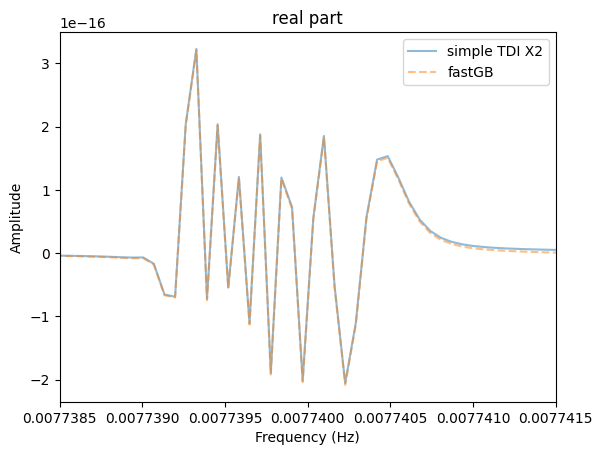

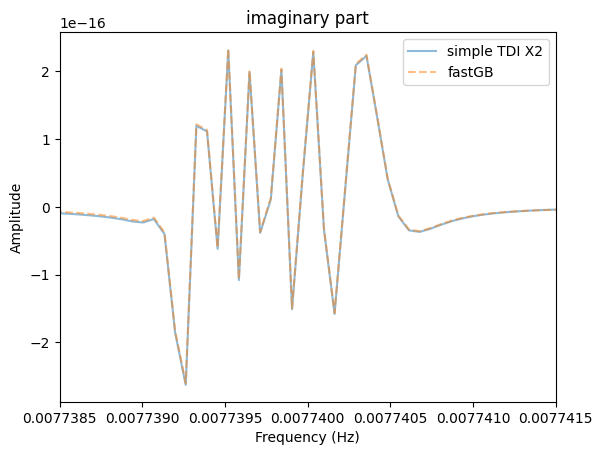

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ldc.lisa.orbits import Orbits
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain
import ldc.io.yml as ymlio
import os
import h5py
import ldc.waveform.fastGB as FB
from ldc.common.series import TimeSeries
from ldc.common import constants

config = {"dt":15.0, "initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic', 
          "t_max": 60*60*24*30*6, "t_min": 0, "travel_time_order": 1}


cat = np.array([tab_Param],
               dtype=[('Amplitude', '<f8'),
                      ('EclipticLatitude', '<f8'),
                      ('EclipticLongitude', '<f8'),
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'),
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'),
                      ('Polarization', '<f8')])

GB = HpHc.type("GB", "GB", "TD_fdot")
GB.set_param(cat)
GWs = GB.split()

globals().update(config)
trange = np.arange(t_min, t_max, dt)
orbits = Orbits.type(config)
P = ProjectedStrain(orbits)
yArm = P.arm_response(t_min, t_max, dt, GWs, tt_order=travel_time_order)

simple_tdi_X = P.compute_tdi_x(trange, tdi2=False)
simple_tdi_X = TimeSeries(simple_tdi_X,dt=dt,t0=t_min)
simple_tdi_X = simple_tdi_X.ts.fft()

simple_tdi2_X = P.compute_tdi_x(trange, tdi2=True)
simple_tdi2_X = TimeSeries(simple_tdi2_X, dt=dt,t0=t_min)
simple_tdi2_X = simple_tdi2_X.ts.fft()

GB = FB.FastGB(delta_t=dt, T=t_max)
pGB = dict(zip(cat.dtype.names, cat[0]))
X, Y, Z = GB.get_fd_tdixyz(template=pGB)
X2, Y2, Z2 = GB.get_fd_tdixyz(template=pGB, tdi2=True)

plt.figure()
plt.title("real part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.real, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.real, alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.xlim([0.0077385,0.0077415])
#plt.xlim([0.00773,0.00775])
plt.legend()
plt.figure()
plt.title("imaginary part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.imag, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.imag, alpha=0.5, label="fastGB",linestyle='dashed')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0.0077385,0.0077415])
plt.legend()


In [149]:
X2_t,Y2_t,Z2_t=GB.get_td_tdixyz(template=pGB,oversample=4,tdi2=True)
print(t_max)
print(len(X2_t))
print(dt)

15552000
1036799
15.0


In [151]:
print(len(X2))

64


1036799


Text(0, 0.5, 'Amplitude')

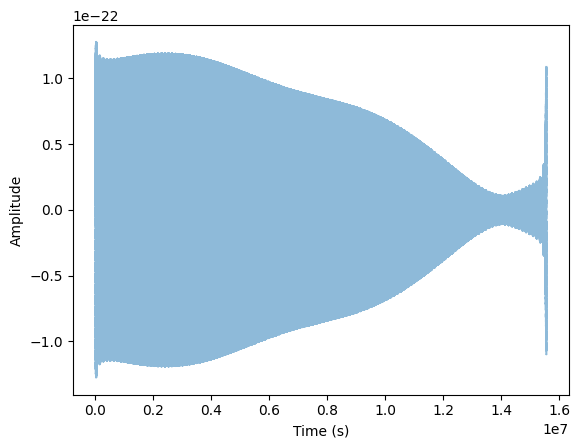

In [8]:
plt.plot(X2_t.t, X2_t, alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

15.20834800187886
1036799


Text(0, 0.5, 'Amplitude')

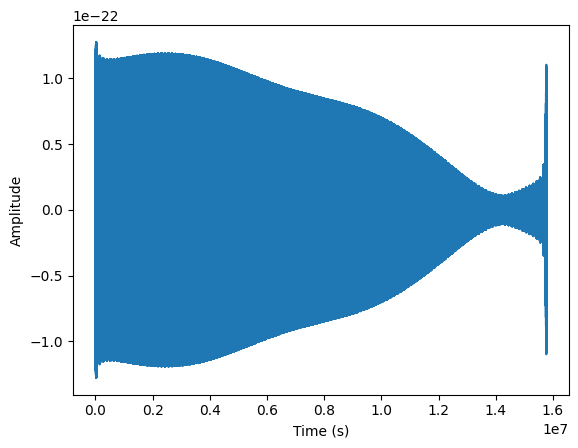

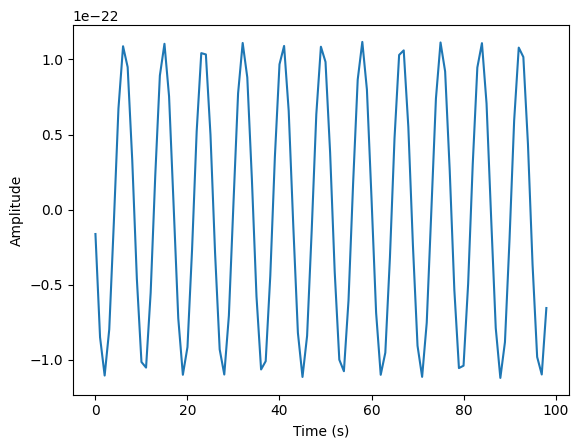

In [9]:
N=len(X2_t)
Tobs = 365*24*60*60*0.5
T=Tobs
dt=T/N

t= np.arange(0, Tobs,T/N)
plt.plot(t,X2_t)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
print(dt)
print(len(t))
plt.figure()
plt.plot(X2_t[:-1036700])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [4]:
#Creation of data
config = {"dt":15.0, "initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic', 
          "t_max": 60*60*24*30*6, "t_min": 0, "travel_time_order": 1}


cat = np.array([tab_Param],
               dtype=[('Amplitude', '<f8'),
                      ('EclipticLatitude', '<f8'),
                      ('EclipticLongitude', '<f8'),
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'),
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'),
                      ('Polarization', '<f8')])

GB = HpHc.type("GB", "GB", "TD_fdot")
GB.set_param(cat)
GWs = GB.split()

globals().update(config)
trange = np.arange(t_min, t_max, dt)
orbits = Orbits.type(config)
P = ProjectedStrain(orbits)
yArm = P.arm_response(t_min, t_max, dt, GWs, tt_order=travel_time_order)


simple_tdi2_X = P.compute_tdi_x(trange, tdi2=True)
simple_tdi2_X_t = TimeSeries(simple_tdi2_X, dt=dt,t0=t_min)
N=len(simple_tdi2_X_t)
print(N)
#print(len(X2_t))

simple_tdi2_X_f=simple_tdi2_X_t.ts.fft()
#print(len(simple_tdi2_X_f))



1036800


In [5]:
#Creation of noisedata
import ldc
from ldc.lisa.noise import get_noise_model
from ldc.lisa.noise import NumericNoise
AddLDC = True

import backgroundsmaster
from backgroundsmaster.backgrounds.utils import generate_noise

f_sampling=1/dt
#get_noise_model("SciRDv1",f).psd(option='X',tdi2=True)

c=299792458.0
L_m = 2.5e9
L = L_m/c
#omegaL = 2*np.pi*f*L
f1=0.4e-3
def Sn_X2(f):
    S_I=5.76e-48*(1+(f1/f)**2)
    S_II=3.6e-41
    return (4*np.pi*f*L)**2*(np.sin(np.pi*f*L))**2*(2*np.sin(2*np.pi*f*L))**2*((S_I/(2*np.pi*f*L)**4)+S_II)

def PSD_Noise_components(fr):
    [sqSacc_level, sqSoms_level] = [3e-15,15e-12]
    # sqSacc_level: Amplitude level of acceleration noise [3e-15]
    # sqSoms_level: Amplitude level of OMS noise [15e-12]
    
    
    ### Acceleration noise
    Sa_a = sqSacc_level**2 *(1.0 +(0.4e-3/fr)**2)*(1.0+(fr/8e-3)**4)
    Sa_d = Sa_a*(2.*np.pi*fr)**(-4.)
    Sa_nu = Sa_d*(2.0*np.pi*fr/c)**2

    ### Optical Metrology System
    Soms_d = sqSoms_level**2 * (1. + (2.e-3/fr)**4)
    Soms_nu = Soms_d*(2.0*np.pi*fr/c)**2
    
    return [Sa_nu, Soms_nu]
def Sn_bis(f):
    [Sa_nu,Soms_nu] = PSD_Noise_components(f)
    return 64 * (np.sin(2*np.pi*f*L))**2 * (np.sin(2*2*np.pi*f*L))**2 * (Soms_nu + Sa_nu*(3+np.cos(2*2*np.pi*f*L)))
tab_noise_t=generate_noise(psd_func=Sn_X2, n_data=N, fs=f_sampling)
#tab_noise_tbis=generate_noise(psd_func=Sn_bis, n_data=N, fs=f_sampling)
#noise_model= get_noise_model('SciRDv1', f[1:], wd=white_dwarf).psd(option='X',tdi2=True)

[ 7.73857239e-22  1.51928541e-22 -5.46207430e-22 ...  1.82897005e-21
 -1.36454831e-21 -1.70239493e-21]


Text(0, 0.5, 'Amplitude')

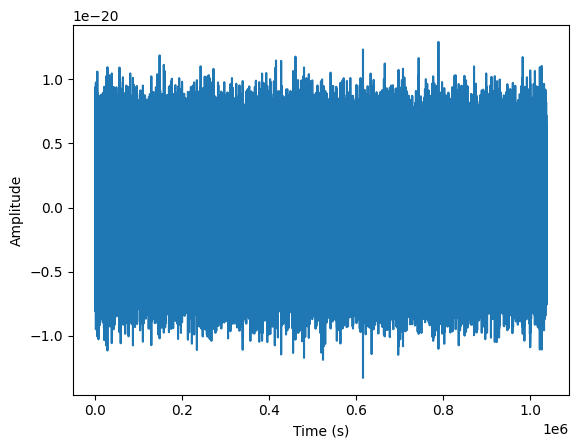

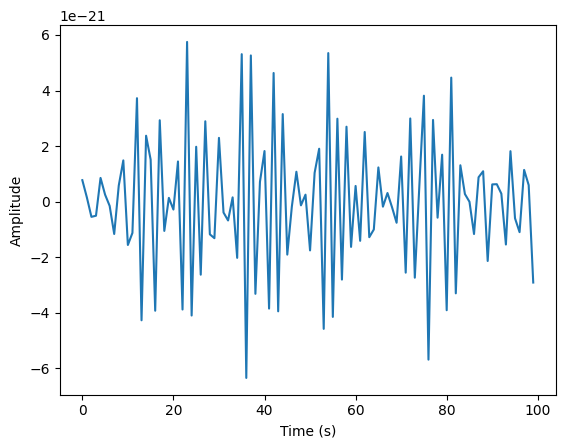

In [6]:
print(tab_noise_t)
plt.plot(tab_noise_t)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.figure()
plt.plot(tab_noise_t[:-1036700])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [ ]:
noise_model= get_noise_model("SciRDv1", f[1:],w).psd(option='X',tdi2=True)
print(type(noise_model))
plt.loglog(f[1:],noise_model)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
print(len(f))

518401


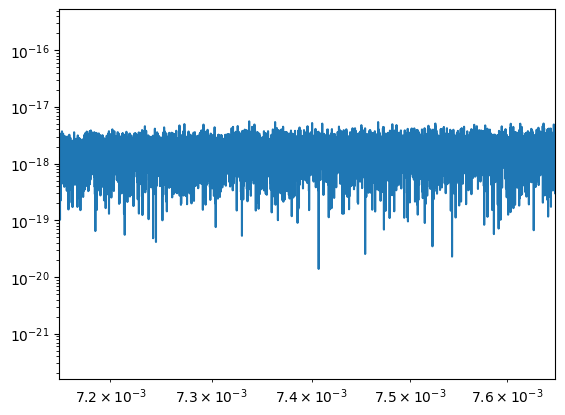

In [15]:
f=np.fft.rfftfreq(N,dt)
def FT_norm(x,dt):
    #window=np.blackman(len(x))
    window=1
    #N_w=np.sum(window**2)
    N_w=len(x)
    return dt*(np.abs(np.fft.rfft(window*x)))

tab_noise_f=FT_norm(tab_noise_t,dt)
plt.loglog(f,(tab_noise_f))
plt.xlim([0.00715,0.00765])
print(len(tab_noise_f))


(0.0077385, 0.0077415)

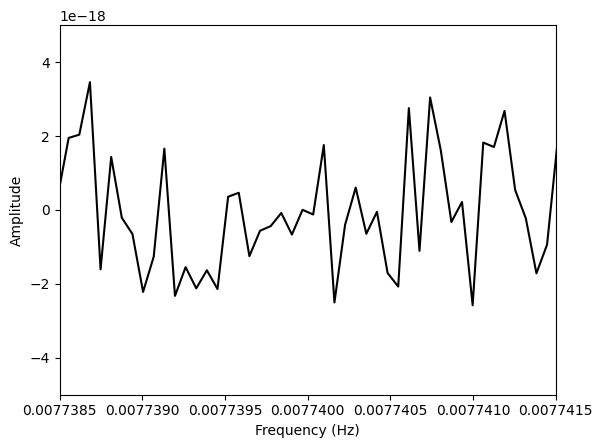

In [8]:
Tobs=t_max
t = np.linspace(0,Tobs,N)
s = tab_noise_t
time_n = TimeSeries(s, t0=0, dt=dt)
freq_n=time_n.ts.fft()

plt.plot(freq_n.f, freq_n.real,
         label="TDI X (noisy)",
         color='black')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.ylim(-0.5e-17,0.5e-17)
plt.xlim([0.0077385,0.0077415])

In [16]:
#SNR
s_x = get_noise_model("SciRDv1",X2.f).psd(option='X', tdi2=True)
snr_x = (4.0*X2.df) * np.sum(np.abs(X2)[:]**2/s_x)
print("Computed SNR is " + str(np.sqrt(float(snr_x))))

Computed SNR is 90.39465710657109


<xarray.DataArray 'f' (f: 777)>
array([0.007715, 0.007715, 0.007715, ..., 0.007765, 0.007765, 0.007765])
Coordinates:
  * f        (f) float64 0.007715 0.007715 0.007715 ... 0.007765 0.007765
Attributes:
    units:    Hz
1036800


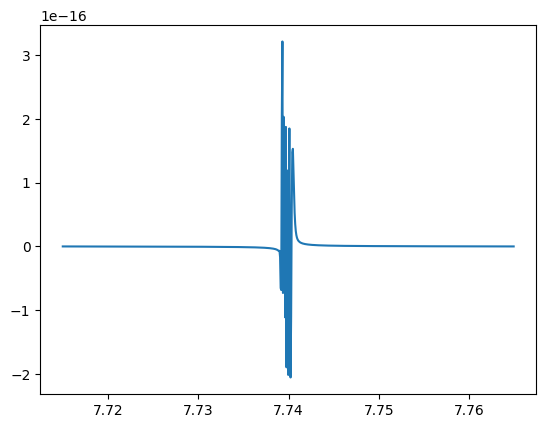

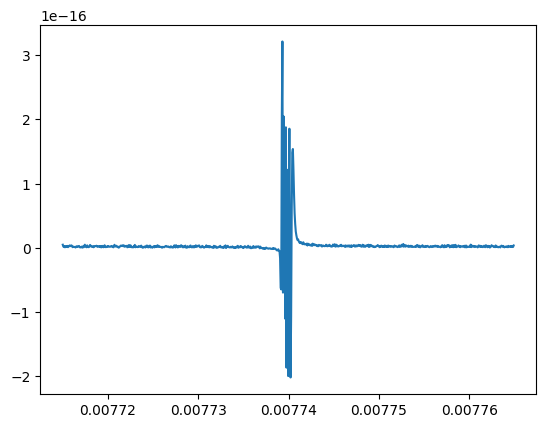

In [71]:
#Compute noisydata d_bis
f_tot=np.fft.fftfreq(N)/dt
GB = FB.FastGB(delta_t=dt, T=t_max)
pGB = dict(zip(cat.dtype.names, cat[0]))
X2_f, Y2_f, Z2_f = GB.get_fd_tdixyz(template=pGB, tdi2=True,freqs=f_n)
plt.plot(X2_f.f*1e3,X2_f)
#plt.xlim([7.715,7.765])
print(X2_f.f)
print(len(f_tot))
d_bis=X2_f+tab_noise_f[id]
plt.figure()
plt.plot(f_n,d_bis)

(-5e-18, 2.5e-16)

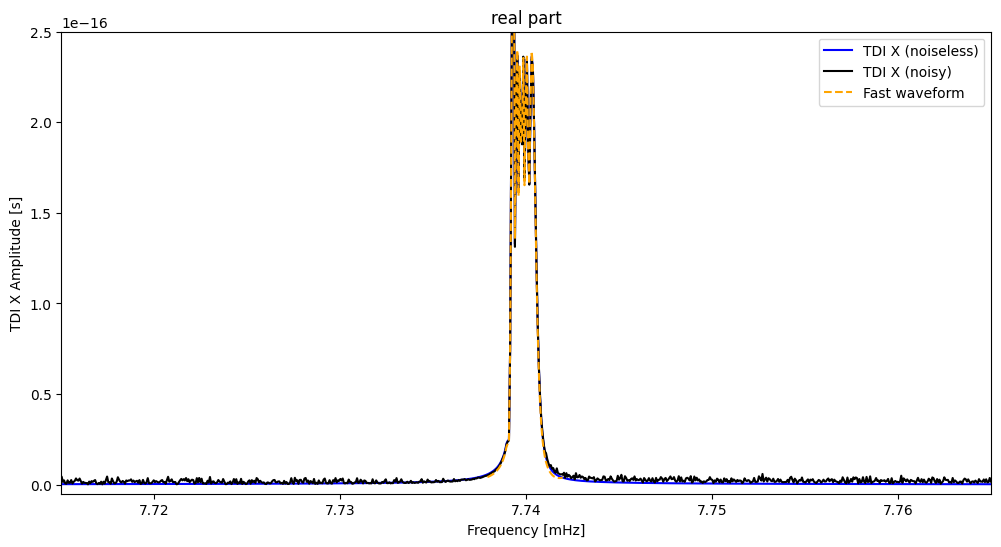

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(111)
plt.title("real part")
plt.plot(simple_tdi2_X_f.f*1e3,np.abs(simple_tdi2_X_f),
         label="TDI X (noiseless)",
         color="blue")
plt.plot(f* 1e3,np.abs(d),
         label="TDI X (noisy)",
         color='black')
plt.plot(X2.f*1e3, np.abs(X2),
         label="Fast waveform",
         color="orange",
         linestyle='dashed')
plt.legend(loc="upper right")
plt.xlabel("Frequency [mHz]")
plt.ylabel("TDI X Amplitude [s]")
plt.xlim([7.715,7.765])
plt.ylim([-0.05e-16,2.5e-16])


In [19]:
#Definition of the frequency window 
pos_1=[]
pos_2=[]
def position(freq,tf):
    for f,i in zip (freq,range(len(tf))):
        if f>=7.715e-3:
            pos_1.append(i)
            p1=pos_1[0]
        if f<=7.765e-3:
            pos_2.append(i)
            p2=pos_2[-1]
    return p1,p2

p1,p2=position(f,simple_tdi2_X_f)
print(p1)
print(p2)
print("Size of new window :",p2-p1)


119984
120761
Size of new window : 777


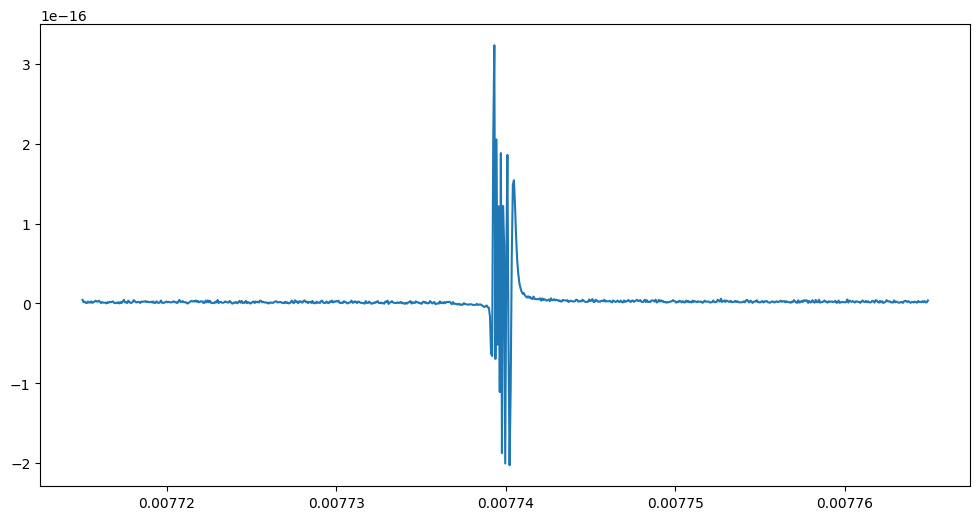

In [20]:
f_n=f[p1:p2]
d_n=d[p1:p2]
plt.figure(figsize=(12,6))
plt.plot(f_n,d_n)

In [123]:
def par2dic(par):
    """
    Transforms parameter array into a dictionnary.

    Parameters
    ----------
    par : ndarray
        waveform parameters:
        Amplitude
        Ecliptic latitude
        Ecliptic longitude
        Frequency
        Frequency derivative
        Inclination
        Initial phase
        Polarization

    """
    pgb = dict({'Amplitude': par[0],# "strain"
              'EclipticLatitude': par[1], # "radian"
              'EclipticLongitude': par[2],# "radian"
              'Frequency': par[3], #"Hz"
              'FrequencyDerivative': par[4],# "Hz^2"
              'Inclination': par[5],# "radian"
              'InitialPhase': par[6], #"radian"
              'Polarization': par[7]}) #"radian"

    return pgb


def waveform2sample(par):
    """
    Tramsform waveform parameters into a format suitable for sampling

    Parameters
    ----------
    par : ndarray
        waveform parameters
        # Amplitude
        # Ecliptic latitude
        # Ecliptic longitude
        # Frequency
        # Frequency derivative
        # Inclination
        # Initial phase
        # Polarization

    Returns
    -------
    psample : ndarray
        log10(amplitude), frequency in mHz, log10(frequency derivative)
        sin(Latitude), Longitude, cos(inclination), polarization, Initial phase

    """

    Amp, bet, lam, f0, fdot, iota, phi0, psi = par
    sin_b = np.sin(bet)
    cos_i = np.cos(iota)
    l_Amp = np.log10(Amp)
    l_fdot = np.log10(fdot)

    p_sample = np.array([l_Amp, f0*1.e3, l_fdot, sin_b, lam, cos_i, psi, phi0])

    return p_sample


def waveform_from_samplepar(pars, freqs=None):
    """

    Compute the waveform in X, Y, Z from sampling parameters


    Parameters
    ----------
    pars : ndarray
        log10(amplitude),
        frequency in mHz,
        log10(frequency derivatite)
        sin(Latitude),
        Longitude,
        cos(inclination),
        polarization,
        Initial phase


    Returns
    -------
    Xf, Yf, Zf : FrequencyArrays
        Waveform in the frequency domain in TDI X, Y, Z [second]

    """
    pp = pars[:]
    l_Amp = pp[0]
    mf0 = pp[1]
    l_fdot = pp[2]
    sin_bet = pp[3]
    lam = pp[4]
    cos_iota = pp[5]
    psi = pp[6]
    phi0 = pp[7]

    # Transform sampling parameters into waveform parameters
    iota = np.arccos(cos_iota)
    beta = np.arcsin(sin_bet)
    Amp = 10.0**l_Amp
    f0 = mf0 *1.e-3
    fdot = 10.0**l_fdot

    pgb = dict({'Amplitude': Amp,# "strain"
              'EclipticLatitude': beta, # "radian"
              'EclipticLongitude': lam,# "radian"
              'Frequency': f0, #"Hz"
              'FrequencyDerivative': fdot,# "Hz^2"
              'Inclination': iota,# "radian"
              'InitialPhase': phi0, #"radian"
              'Polarization': psi}) #"radian"

    Xf, Yf, Zf = GB.get_fd_tdixyz(template=pgb, oversample=4, tdi2=True, freqs=freqs)
    #Xf, Yf, Zf = GB.get_fd_tdixyz(template=pgb, tdi2=True, freqs=freqs)
    
    return Xf,Yf,Zf


def loglike(pars, dataf, id):
    """
    Log-likelihood

    Parameters
    ----------
    pars : ndarray
        array of sampling parameters :
        log10(amplitude)
        frequency (mHz)
        log10(frequencyDerivative)
        sinus(beta) : sinus of latitude
        lambda : longitude
        cos(i) : cosinus of inclination
        psi : polarization angle [rad]
        phi0 : initial phase [rad]
    dataf : ndarray
        full data in the frequency domain
    id : ndarray
        indices of the frequency bins to consider

    Returns
    -------
    loglik : float
        likelihood value

    """

    #freqs = dataf.f[id]
    freqs=f_n
    Xf, Yf, Zf = waveform_from_samplepar(pars, freqs=freqs)
    
    df = 1/GB.T
    # # Index of the first data frequency
    # ib = int(freqs[0] / df)
    # # Index of the last data frequency
    # ie = int(freqs[-1] / df)

    f0 = pars[1]*1e-3
    #Sn = noise_model.psd(freq=f0, option='X', tdi2=True)
    Sn=get_noise_model("SciRDv1",f0).psd(option='X',tdi2=True)

    #Xf = Xf/df
    SNR2 = np.sum(np.real(d_bis*np.conjugate(Xf)))
    hh = np.sum(np.absolute(Xf)**2)
    loglik = 4.0*df*( SNR2 - 0.5 * hh )/Sn#-1/2*np.sum(np.real(d_bis*np.conjugate(d_bis)))

    return float(loglik)

In [22]:
id=np.arange(p1,p2)
print(len(id))

777


In [24]:
print(len(cat))
print(cat[0])
print(type(cat[0]))
cat_a=np.array(cat[0])
print(type(cat_a))
#print(len(cat_a))
param_array=np.array([1.43327232e-22, 0.2856307, 0.81587285, 0.00774, 2.3961e-21, 0.25130486, 2.62732895, 3.71333055])
print(len(param_array))

1
(1.43327232e-22, 0.2856307, 0.81587285, 0.00774, 2.3961e-21, 0.25130486, 2.62732895, 3.71333055)
<class 'numpy.void'>
<class 'numpy.ndarray'>
8


In [29]:
#t1_param=par2dic(param_array)
t2_param=waveform2sample(param_array)
print(t2_param)

[-21.84367129   7.74       -20.62049506   0.28176265   0.81587285
   0.96858877   3.71333055   2.62732895]


In [30]:
p_test = np.array([np.log10(cat[0][0]),(cat[0][0])*1e3,np.log10(cat[0][4]),np.sin(cat[0][1]),cat[0][2],np.cos(cat[0][5]),cat[0][7],cat[0][6]])
print(p_test)
p_sample_true = waveform2sample(param_array)
print(p_sample_true)

[-2.18436713e+01  1.43327232e-19 -2.06204951e+01  2.81762658e-01
  8.15872850e-01  9.68588771e-01  3.71333055e+00  2.62732895e+00]
[-21.84367129   7.74       -20.62049506   0.28176265   0.81587285
   0.96858877   3.71333055   2.62732895]


In [31]:
# Lower bounds
a = np.array([t2_param[0] - 1, t2_param[1] - 1e-3, -24.0, -1.0, -np.pi, -1.0, 0.0, 0.0])
# Upper bounds
b = np.array([t2_param[0] + 1, t2_param[1] + 1e-3, -18.0, 1.0, np.pi, 1.0, 2.0*np.pi, 2.0*np.pi])

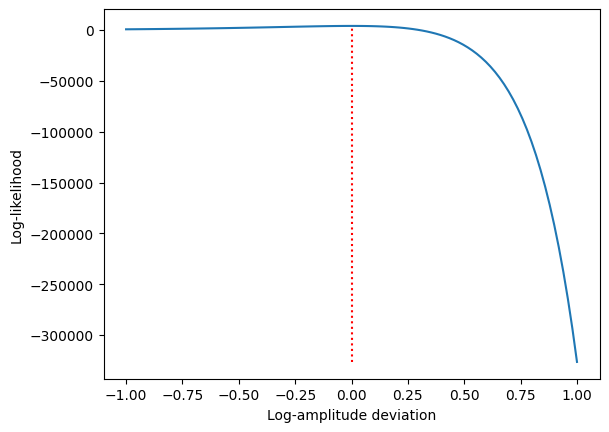

In [117]:
GB = FB.FastGB(delta_t=dt, T=t_max)
import copy
from ldc.lisa import noise

nvalues = 100
prange = np.linspace(a[0], b[0], nvalues)
dps = prange - p_sample_true[0]
l_vect = np.zeros(nvalues)
s_vect = np.zeros(nvalues)
ps = copy.deepcopy(p_sample_true)
# plt.figure(0)
for i in range(nvalues):
    ps[0] = prange[i]
    l_vect[i] = loglike(ps, d, id)
# Likelihood at true parameter value
l_true = loglike(p_sample_true, d, id)

plt.figure(0)
plt.plot(dps, l_vect)
plt.xlabel("Log-amplitude deviation")
plt.ylabel("Log-likelihood")
plt.vlines(x=0.0, ymin=np.min(l_vect), ymax=l_true,
           label='True value', color='red', linestyle='dotted')
plt.show()

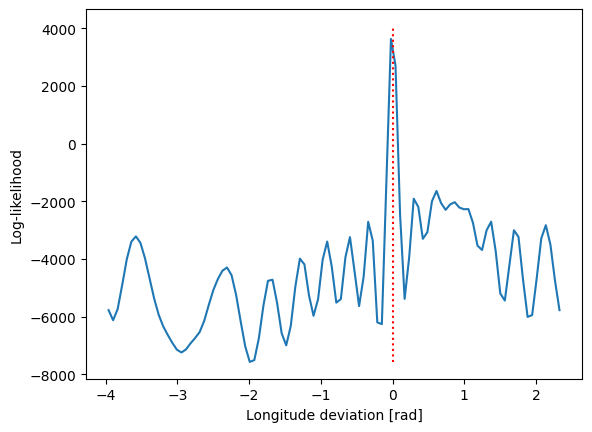

In [125]:
# Varying the longitude
nvalues = 100
prange = np.linspace(a[4], b[4], nvalues)
dps = prange - (p_sample_true[4])
l_vect = np.zeros(nvalues)
s_vect = np.zeros(nvalues)
ps = copy.deepcopy(p_sample_true)

for i in range(nvalues):
    ps[4] = prange[i]
    l_vect[i] = loglike(ps, d, id)
# Likelihood at true parameter value
l_true = loglike(p_sample_true, d, id)
# Plot
plt.figure(0)
plt.plot(dps, l_vect)
plt.xlabel("Longitude deviation [rad]")
plt.ylabel("Log-likelihood")
plt.vlines(x=0.0, ymin=np.min(l_vect), ymax=l_true,
           label='True value', color='red', linestyle='dotted')
plt.show()

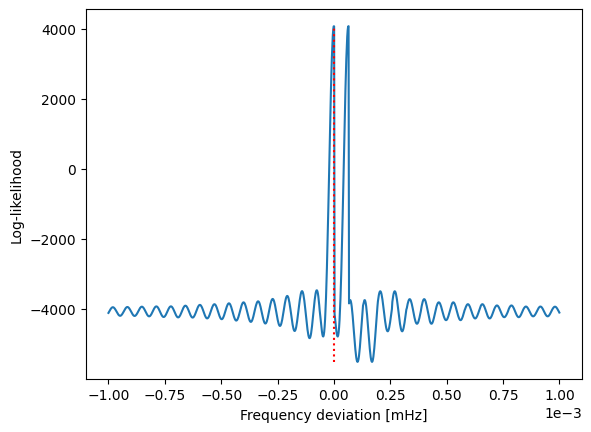

In [124]:
# Varying the frequency
nvalues = 1000
prange = np.linspace(a[1], b[1], nvalues)
dps = prange - p_sample_true[1]
l_vect = np.zeros(nvalues)
s_vect = np.zeros(nvalues)
ps = copy.deepcopy(p_sample_true)
# plt.figure(0)
for i in range(nvalues):
    ps[1] = prange[i]
    l_vect[i] = loglike(ps, d_bis, id)
# Likelihood at true parameter value
l_true = loglike(p_sample_true, d_bis, id)

plt.figure(0)
plt.plot(dps, l_vect)
plt.xlabel("Frequency deviation [mHz]")
plt.ylabel("Log-likelihood")
plt.vlines(x=0.0, ymin=np.min(l_vect), ymax=l_true,
           label='True value', color='red', linestyle='dotted')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

In [23]:
#sampler 
#priors
from scipy.special import gamma

Phi_s=10**(-3)
logMass_s=8.4
M_star=10**logMass_s
a=-1.19
beta2=0.5116394637708428
alpha_moy=0.12
alpha=alpha_moy
chi=0.5

def Dist_BH(M,d):
    return ((1/(d+1))**(beta2)*Phi_s*(M/M_star)**(1+a)*np.exp(1-(M/M_star)))

def P_M(M):
    return (Phi_s*(M/(M_star))**(1+a)*np.exp(1-(M/M_star)))

#Amplitudeh_0
m=1
def chi_f(alpha_f):
    return (4*alpha_f*m)/(4*alpha_f*m+m)
    
def dist_z(z):
    #return Phi_s*(M_star/z)**(2-beta2)*np.exp(1)*gamma(a-beta2+3)
    return (1/(1+z)**beta2)


C1=float((8e-28/10)*(alpha/0.1)**7*(10**6)*((chi-0.45)/0.1))
C1_Mpc=(8e-28/10)*(alpha/0.1)**7*((chi-0.45)/0.1)
H=float((2*c/70)*1e-3)

def P_d(x):
    return ((H*d1)**(beta2-1)/(x-d0+H*d1)**(beta2))

def logP_h0local(x):
    x=10**x
    return -np.log(C1_Mpc)+np.log(Phi_s)+(1+a)*(np.log(x)-np.log(C1_Mpc*M_star))+(1-(x/C1_Mpc)/M_star)

def logP_h0Brito(x):
    x=10**x
    return np.log((1/C1_Mpc)*(0.005*((x/C1_Mpc)/3*10**6)**(0.3)))

#frequency
C2=(645*10*alpha_moy)/0.1
def logP_f0(x):
    x=float(x*1e-3)
    return 1+np.log(C2*Phi_s)+(1+a)*(np.log(C2/M_star)-np.log(x))-(2*np.log(x)+(C2/(x*M_star)))


#frequency derivative

C3=3e-14*10**2*(alpha/0.1)**19*chi**2
def logP_f0dot(x):
    x=float(10**x) 
    return 1+np.log(Phi_s/2)+(1+a/2)*np.log(C3)-(1+a)*np.log(M_star)-(2+a/2)*np.log(x)-np.sqrt(C3/x)/M_star

In [29]:
def logprior_set(theta,a,b):
    if (np.all(a <=theta) and np.all(b >= theta)):
        logh0,f,logfdot,sinbeta,lamb,cos_i,pol,ph=theta
        p=float(logP_h0local(logh0)+logP_f0(f)+logP_f0dot(logfdot))
    
    else :
        p=-np.inf
       
    return p
           

In [30]:
# Lower bounds
a_tab = np.array([t2_param[0] - 1, t2_param[1] - 1e-3, -22.0, -1.0, -np.pi, -1.0, 0.0, 0.0])
# Upper bounds
b_tab = np.array([t2_param[0] + 1, t2_param[1] + 1e-3, -18.0, 1.0, np.pi, 1.0, 2.0*np.pi, 2.0*np.pi])

In [115]:
print(a_tab)
print(b_tab)
print(logprior_set(t2_param,a_tab,b_tab))

[-24.84367129   7.739      -22.          -1.          -3.14159265
  -1.           0.           0.        ]
[-18.84367129   7.741      -18.           1.           3.14159265
   1.           6.28318531   6.28318531]
115.64215268108391


In [34]:
# Run the sampler (long!)
result = sampler.run_mcmc(p0=pos, iterations=nit, thin=thin)
chaindata = sampler.chain[:]


NameError: name 'sampler' is not defined

In [32]:
import corner
import ptemcee
from PTMCMCSampler import PTMCMCSampler
import time

class HDF5Store(object):
    """
    Simple class to append value to a hdf5 file on disc (usefull for building keras datasets)
    
    Params:
        datapath: filepath of h5 file
        dataset: dataset name within the file
        shape: dataset shape (not counting main/batch axis)
        dtype: numpy dtype
    
    Usage:
        hdf5_store = HDF5Store('/tmp/hdf5_store.h5','X', shape=(20,20,3))
        x = np.random.random(hdf5_store.shape)
        hdf5_store.append(x)
        hdf5_store.append(x)
        
    From https://gist.github.com/wassname/a0a75f133831eed1113d052c67cf8633
    """
    def __init__(self, datapath, dataset, shape, dtype=np.float32, 
                 compression="gzip", chunk_len=1):
        self.datapath = datapath
        self.dataset = dataset
        self.shape = shape
        self.i = 0

        # Create the file if it does not already exists
        if not os.path.isfile(self.datapath):
            with h5py.File(self.datapath, mode='w') as h5f:
                self.dset = h5f.create_dataset(
                    dataset,
                    shape=(0, ) + shape,
                    maxshape=(None, ) + shape,
                    dtype=dtype,
                    compression=compression,
                    chunks=(chunk_len, ) + shape)
    
    def append(self, values):
        """
        Append more value to dataset.
        
        Parameters
        ----------
        values : ndarray
            Array of values to append. Should have shape (n_values, shape)
        
        """
        with h5py.File(self.datapath, mode='a') as h5f:
            dset = h5f[self.dataset]
            values_shape = np.shape(values)
            
            # Check that the number of dimensions is the same
            if len(values_shape) == len(self.shape):
                n_values = 1
            # If it's not, there is more than one value to add
            elif len(values_shape) > len(self.shape):
                n_values = values_shape[0]
            else:
                raise ValueError("There is a dimension problem.")
            dset.resize((self.i + n_values, ) + self.shape)
            dset[-n_values:] = [values]
            self.i += n_values
                
            h5f.flush()

    def load(self):
        with h5py.File(self.datapath, mode='r') as h5f:
            dset = h5f[self.dataset][()]
        return dset    

    @staticmethod
    def chain_to_save(chain):
        ntemps, nwalkers, nsteps, ndim = np.shape(chain)
        reshaped_chain = np.zeros((nsteps, ntemps, nwalkers, ndim))
        for i in range(nsteps):
            reshaped_chain[i, :, :, :] = chain[:, :, i, :]
        
        return reshaped_chain
    
    @staticmethod
    def save_to_chain(reshaped_chain):

        nsteps, ntemps, nwalkers, ndim = np.shape(reshaped_chain)
        chain = np.zeros((ntemps, nwalkers, nsteps, ndim))
        for i in range(nsteps):
            chain[:, :, i, :] = reshaped_chain[i, :, :, :]
        
        return chain


In [33]:
ndim = len(t2_param)
nwalkers = 8 * ndim
ntemps = 20
nit = 1000
thin = 1

# Instantiate the sampler
sampler = ptemcee.Sampler(nwalkers, ndim, loglike,
                              logprior_set, ntemps=int(ntemps),
                              loglargs=[d_n,id],
                              logpargs=[a_tab,b_tab],
                              pool=None)

In [ ]:
# Intialize the parameter state
pos = np.random.uniform(low=a_tab,high=b_tab,size=(ntemps, nwalkers, ndim))

# Number of iterations
n_iter = 1000
n_thin = 1
# Save results every 100 samples
n_save = 100
# Print progress every 200 samples
n_verbose = 200
# Initialize iteration counter
i = 0
isave = 0

output_dir = "./"
chain_suffix = "mychains10.h5"
# logl_suffix = "mylogl.h5"
# logp_suffix = "mylogp.h5"

hdf5 = HDF5Store(output_dir + chain_suffix, 
                 "chains", 
                 np.shape(pos), 
                 dtype=float, 
                 compression="gzip", 
                 chunk_len=1)

# Block of chain to be saved
nsize = np.min([n_save, n_iter])
chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
logl_save = np.zeros((ntemps, nwalkers, nsize))
logp_save = np.zeros((ntemps, nwalkers, nsize))
t1 = time.time()
for pstate, lnlike0, lnprob0 in sampler.sample(pos, n_iter, thin=n_thin, storechain=True):

    # Store data
    chain_save[:, :, isave, :] = pstate
    logl_save[:, :, isave] = lnlike0
    logp_save[:, :, isave] = lnprob0

    if isave == n_save - 1:
        # If the number of iterations in a multiple of n_save
        print("Save data at iteration " + str(i) + "...")
        # The number of saved iterations at iteration i is
        # saved_it = i // thin
        # ------Samples---------

        hdf5.append(hdf5.chain_to_save(chain_save))
        # ------Log likelihood---------
        # ------Log prior---------
        print("Data saved.")
        # Update the number of samples saved
        isave += nsize
        # Once data is saved, re-initialize the arrays
        nsize = np.min([n_save, n_iter-i])
        chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
        logl_save = np.zeros((ntemps, nwalkers, nsize))
        logp_save = np.zeros((ntemps, nwalkers, nsize))
        # Set the saving counter to zero
        isave = 0
    else:
        # increment saving counter
        isave += 1
    
    if i % (n_verbose -1) == 0:
        print("Iteration " + str(i) + " completed.")
    # Increment global counter
    i += 1


t2 = time.time()
print(t2-t1)

Iteration 0 completed.
Save data at iteration 99...
Data saved.
Save data at iteration 199...
Data saved.
Iteration 199 completed.
Save data at iteration 299...
Data saved.
Iteration 398 completed.
Save data at iteration 399...
Data saved.
Save data at iteration 499...
Data saved.
Iteration 597 completed.
Save data at iteration 599...
Data saved.


In [30]:
chains = hdf5.save_to_chain(hdf5.load())

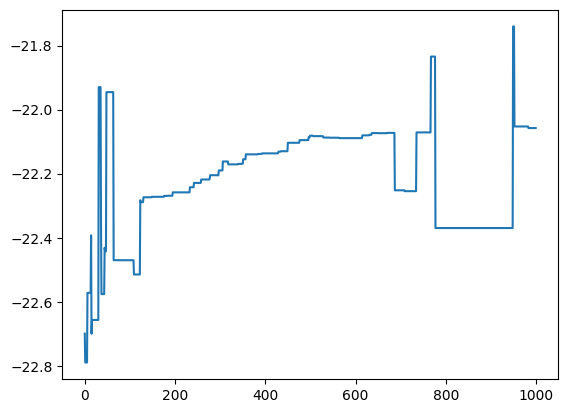

In [31]:
plt.figure(0)
plt.plot(chains[0, 0, :, 0])
plt.show()
plt.ylabel(r'$log(h_0)$')
plt.xlabel('Iterations')
plt.savefig('./bh_fig/11')

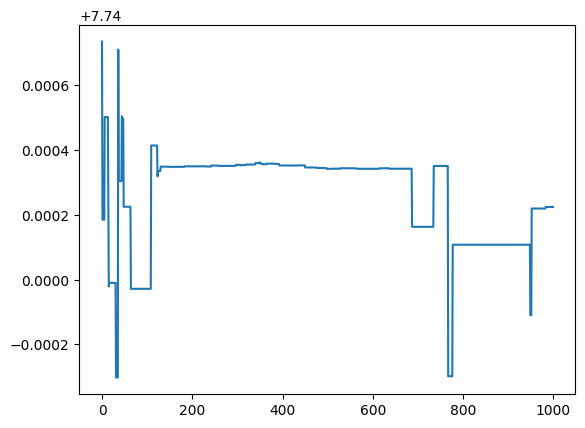

In [32]:
plt.plot(chains[0, 0, :, 1])
plt.show()
plt.ylabel(r'$f_0$')
plt.xlabel('Iterations')
plt.savefig('./bh_fig/12')

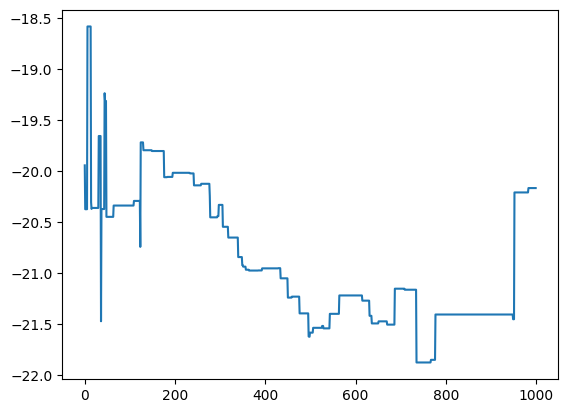

In [33]:
plt.plot(chains[0, 0, :, 2])
plt.show()
plt.ylabel(r'$log(f_0)$')
plt.xlabel('Iterations')
plt.savefig('./bh_fig/13')

In [ ]:
plt.plot(chains[0, 0, :, 3])
plt.ylabel(r'$sin(\beta)$')
plt.xlabel('Iterations')
plt.savefig('./bh_fig/14')

In [ ]:
plt.plot(chains[0, 0, :, 4])
plt.ylabel(r'$\lambda$')
plt.xlabel('Iterations')
plt.savefig('./bh_fig/15')

In [34]:
burnin = 500
samples_plot = chains[0, :, burnin:, :].reshape((nwalkers*(chains.shape[2]-burnin),chains.shape[-1]))

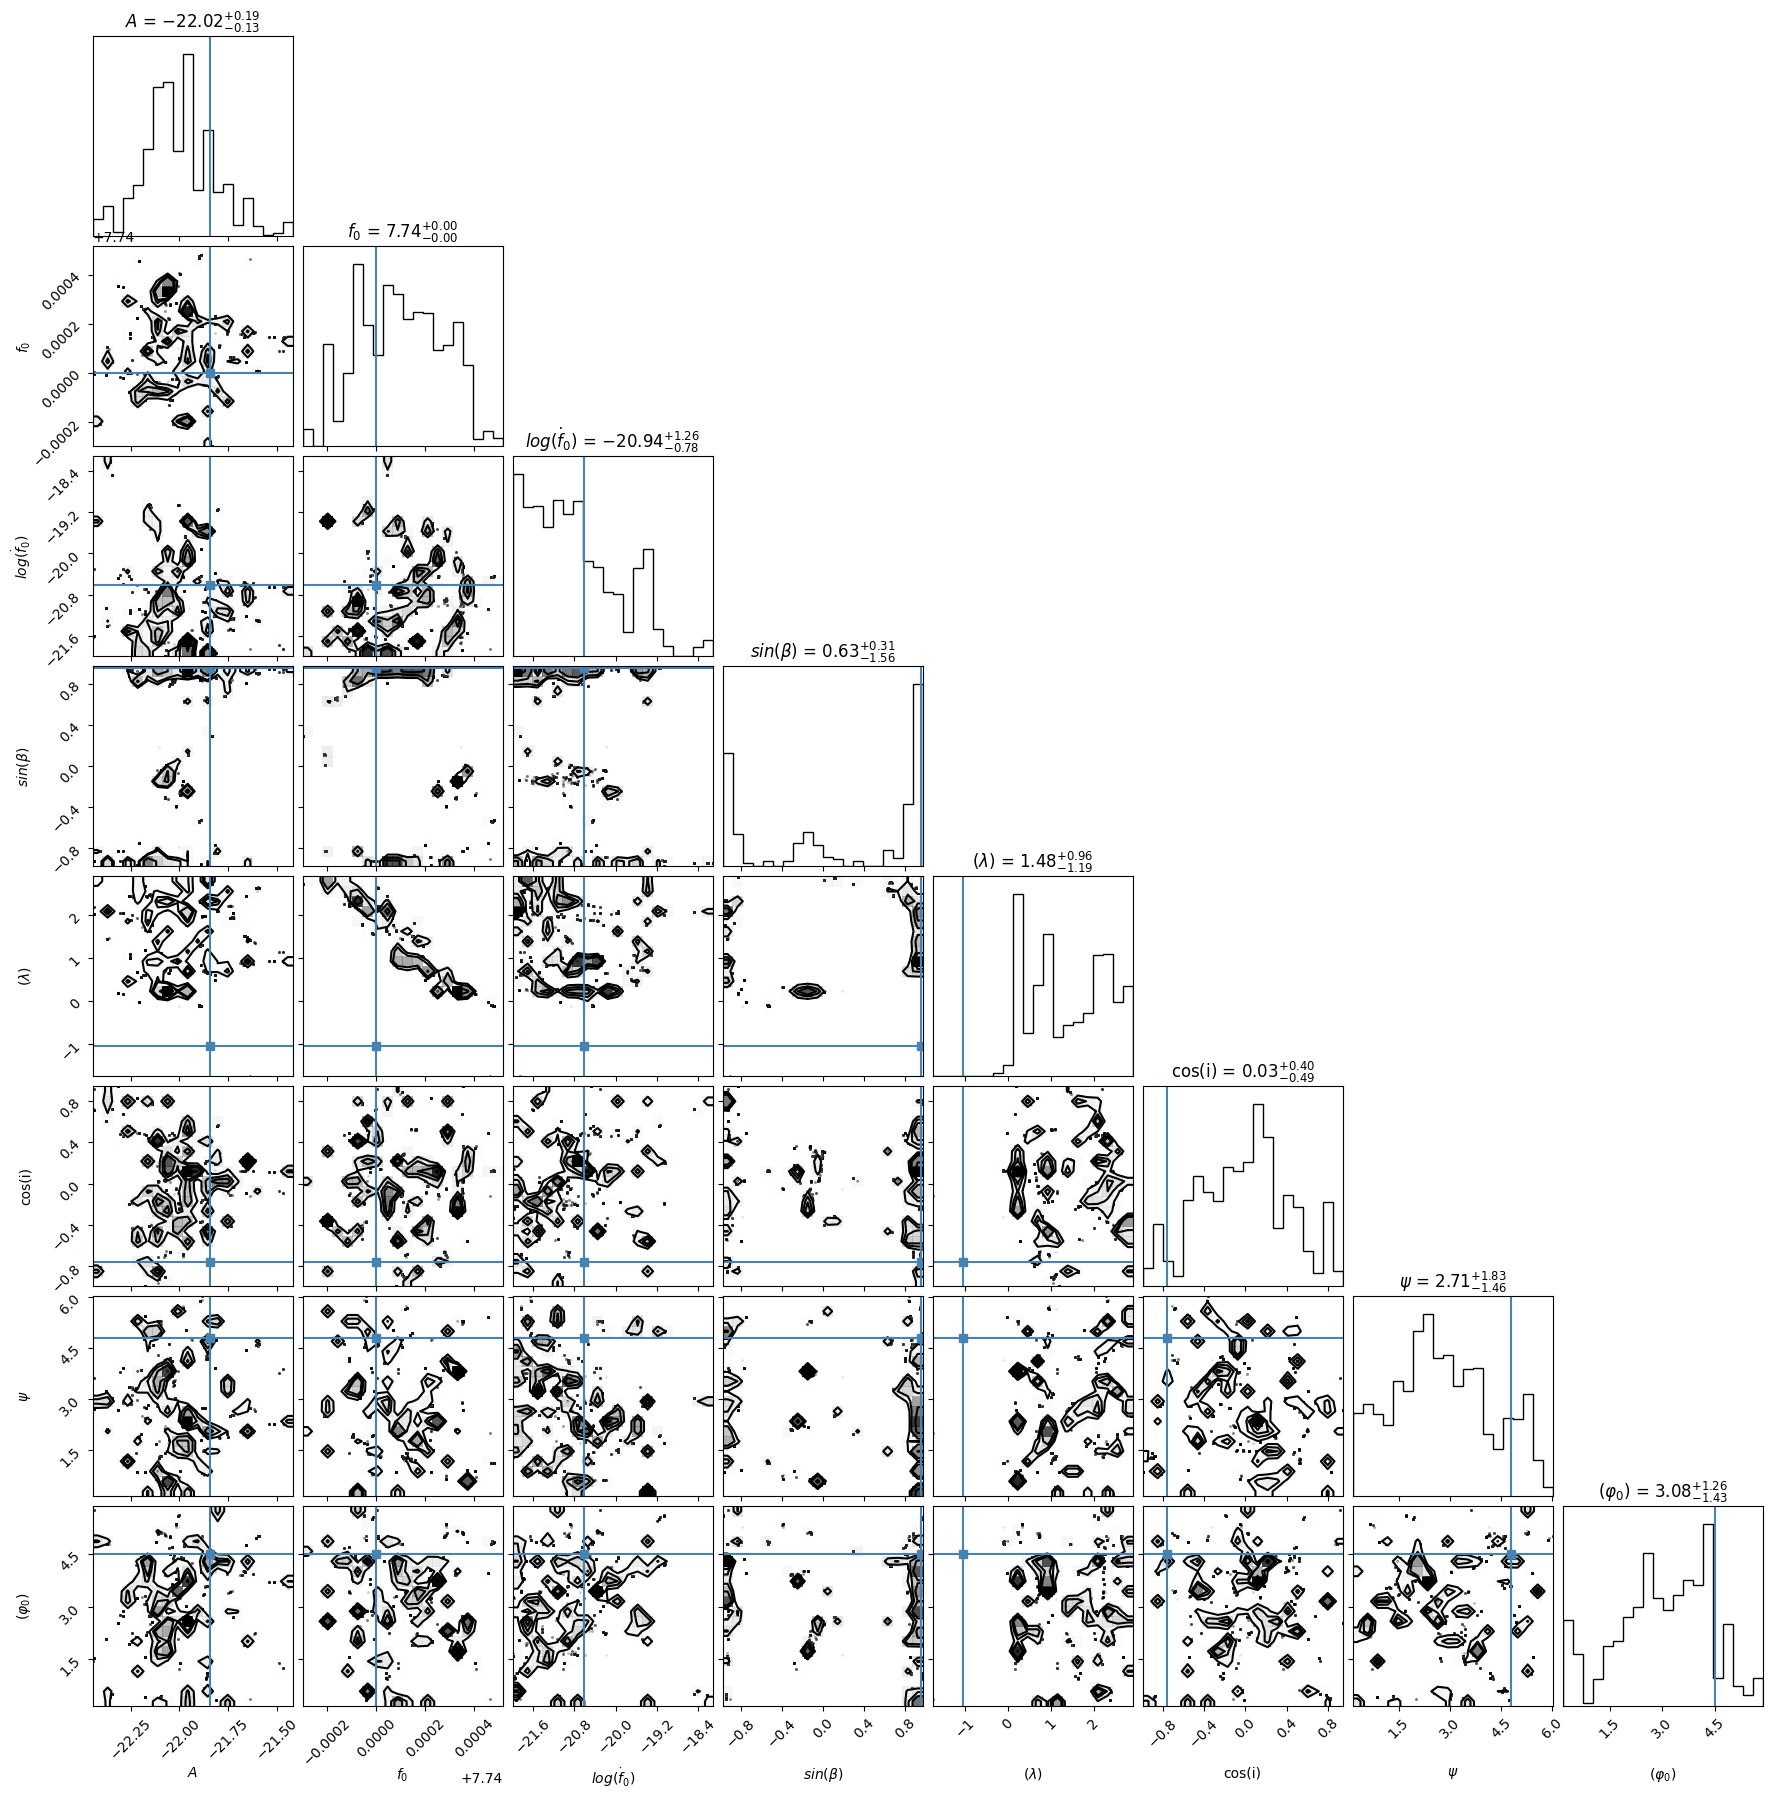

In [39]:
import corner
figure = corner.corner(samples_plot, labels=["$A$", "$f_0$", "$log(\dot{f}_0)$",r"$sin(\beta$)",r"($\lambda$)",r"cos(i)",
                                        r"$\psi$",r"$(\varphi_0)$"],
                      truths=[t2_param[0], t2_param[1], t2_param[2],t2_param[3],t2_param[4],t2_param[5],t2_param[6],t2_param[7]],
                        # quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12})

plt.savefig('cornerplotlocal.png')

In [37]:
#logEvidence calculation
log_modelBH, uncertainty = sampler.log_evidence_estimate()
print("Estimated log evidence for SMBH model = ", log_modelBH, "+/-", uncertainty)

Estimated log evidence for SMBH model =  476.71258559366424 +/- 2.537510214321401


In [112]:
print(np.shape(logp_save))

(20, 64, 1)
